In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

[array([0.5]), array([0.5, 0. ])]
0.5


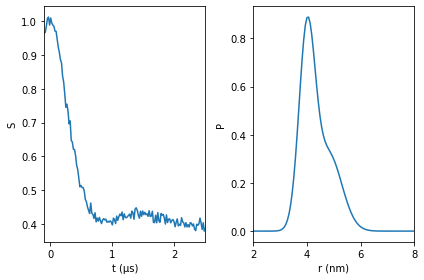

In [3]:
nr = 100
nt = 150

t = np.linspace(-0.1,2.5,nt)        # time axis, µs
r = np.linspace(2,8,nr)      # distance axis, ns

r0 = 4 
fwhm = 0.4 # parameters for three-Gaussian model
Ptrue = dive.dd_gauss(r,r0,fwhm)          # model distance distribution

param2 = [4, 0.3,0.6, 4.8, 0.5, 0.4] # parameters for three-Gaussian model
Ptrue = dl.dd_gauss2(r,param2)  

lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dl.bg_exp(t,k)         # background decay
K = dl.dipolarkernel(t,r,mod = lam, bg = B)    # kernel matrix

sigma = 0.01

# Vtrue = dive.deerTrace(K@P0,B,V0,lam)
Vtrue = K@Ptrue
Vexp = Vtrue + dl.whitegaussnoise(t,sigma,seed=0)

# Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,sigma,seed=0)

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
# line1 = ax[0].plot(t, Vtrue,'k')
line2 = ax[1].plot(r, Ptrue)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [4]:
import warnings
import scipy.integrate
from scipy.special import fresnel

def kernelmatrix_fresnel(t,r):

    ge = 2.00231930436256 # free-electron g factor
    muB = 9.2740100783e-24 # Bohr magneton, J/T 
    mu0 = 1.25663706212e-6 # magnetic constant, N A^-2 = T^2 m^3 J^-1 
    h = 6.62607015e-34 # Planck constant, J/Hz
    w0 = (mu0/2)*muB**2*ge*ge/h*1e21 # Hz m^3 -> MHz nm^3 -> Mrad s^-1 nm^3
    
    #==========================================================================
    """Calculate kernel using Fresnel integrals (fast and accurate)"""
    K = np.zeros((nt,nr))
    wr = w0/(r**3)  # rad s^-1

    # Calculation using Fresnel integrals
    ph = np.outer(np.abs(t), wr)
    kappa = np.sqrt(6*ph/np.pi)
    
    # Supress divide by 0 warning        
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        S, C = fresnel(kappa)/kappa
    
    K = C*np.cos(ph) + S*np.sin(ph)
    K[t==0] = 1 

    return K

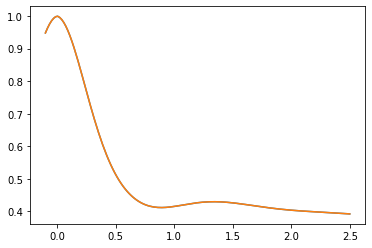

In [7]:
B = dl.bg_exp(t,k)
Bm = np.transpose(np.tile(B,(nr,1)))
Kl = (1-lam)+lam*kernelmatrix_fresnel(t,r)    # kernel matrix 
KB = Kl*Bm

dr = r[1]-r[0]
KB = KB*dr

Vnew = (KB)@Ptrue

# Vnew = (KB)@Ptrue
plt.plot(t,Vtrue)
plt.plot(t,Vnew);

### Setup model

In [8]:
K = kernelmatrix_fresnel(t,r)    # unnormalized kernel matrix
dr = r[1]-r[0]

rn = np.linspace(1,nr,nr) 
L = dl.regoperator(rn,1)
LtL = np.matmul(np.transpose(L),L)

a0 = 0.01
b0 = 1e-6

Pmap = Ptrue

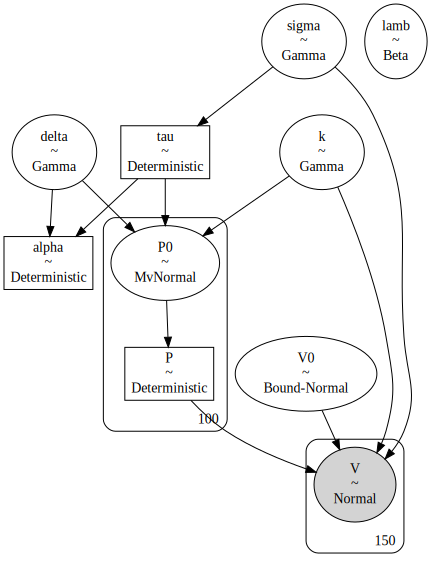

In [9]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # time domainnal
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)
    
    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t,k)         # background decay

    # Calculate matrices and operators - this needs to be computed inside the custom step!!
    Kl = (1-lam)+lam*K
    Bm = T.transpose(T.tile(B,(nr,1)))
    KB = Kl*Bm*dr

    KtK = T.dot(T.transpose(KB),KB)
    KtS = T.dot(T.transpose(KB),Vexp)

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    alpha = pm.Deterministic('alpha',np.sqrt(delta/tau))
    
    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)
    P0 = pm.MvNormal("P0", mu=Pmap, chol = C_L, shape = nr)    
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    # Likelihood
    pm.Normal('V',mu = V0*pm.math.dot(KB,P), sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

### Add custom sampling step for P

In [10]:
from pymc3.step_methods.arraystep import BlockedStep

class SampleRandP(BlockedStep):
    def __init__(self, var, delta, sigma, KtK, KtS, LtL, nr):
            self.vars = [var]
            self.var = var
            self.delta = delta
            self.sigma = sigma
            self.KtK = KtK
            self.KtS = KtS
            self.LtL = LtL
            self.nr = nr

    def step(self, point: dict):
        sigma = np.exp(point[self.sigma.transformed.name])
        tau = 1/(sigma**2)
        delta = np.exp(point[self.delta.transformed.name])
       
        new = point.copy()
        new[self.var.name] = dive.randP(delta,tau,self.KtK,self.KtS,self.LtL,self.nr)

        return new

### Run sampler

In [11]:
with model:
    step_P0 = SampleRandP(P0, delta, sigma, KtK, KtS, LtL, nr)  
    trace = pm.sample(step = step_P0, chains=2, cores=1, draws=2000, tune=1000,return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>SampleRandP: [P0]
>NUTS: [delta, k, V0, lamb, sigma]


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

### Analysis

In [ ]:
dive.summary(trace, model, S, t, r, Ptrue = Pmap)